<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/FFA-net/ffa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing and loading of data

In [ ]:
#ls drive/MyDrive/reside/archive/clear_images drive/MyDrive/reside/archive/haze  

In [2]:
# function to load the image in the form of tensors.

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    img = img / 255.0
    return img

In [3]:
# function to get the path of individual image.

def data_path(orig_img_path, hazy_img_path):
    
    train_img = []
    val_img = []
    
    orig_img = glob.glob(orig_img_path + '/*.jpg')
    n = len(orig_img)
    random.shuffle(orig_img)
    train_keys = orig_img[:int(0.9*n)]        #90% data for train, 10% for test
    val_keys = orig_img[int(0.9*n):]
    
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
        
    hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    for img in hazy_img:
        img_name = img.split('/')[-1]
        orig_path = orig_img_path + '/' + img_name.split('_')[0] + '.jpg'
        if (split_dict[orig_path] == 'train'):
            train_img.append([img, orig_path])
        else:
            val_img.append([img, orig_path])
            
    return train_img, val_img

In [4]:
# function to load tensor image data in batches.

def dataloader(train_data, val_data, batch_size):
    
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [5]:
# function to display output.
import cv2
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()
    #print("input image quality",display_list)#niqe(cv2.imread(display_list[1])))
    #print("input image quality",niqe(cv2.imread(display_list[2])))

# Network Function

In [15]:
def default_conv(in_channels, out_channels, kernel_size, bias=True,activation='relu'):
    return tf.keras.layers.Conv2D(out_channels, kernel_size,padding='same', use_bias=bias,activation=activation)
    
class PixAtLayer(tf.keras.Model):
    def __init__(self, channel):
        super(PixAtLayer, self).__init__()
        self.pa = tf.keras.Sequential()
        self.pa.add(tf.keras.layers.Conv2D(channel // 8, 1, padding='valid',activation='relu'))
        self.pa.add(tf.keras.layers.Conv2D( 1, 1,activation='sigmoid'))
    def call(self, x):
        y = self.pa(x)
        #return y
        return x * y

    def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

class adapavgpooling(tf.keras.Model):
  def __init__(self,outputsize):
    super(adapavgpooling,self).__init__()
    self.outputsize=outputsize

  def call(self,x):
    x_shape=tf.keras.backend.int_shape(x)
    batchsize1,dim1,dim2,channels1=x_shape
    stride=np.floor(dim1/self.outputsize).astype(np.int32)
    kernels=dim1-(self.outputsize-1)*stride
    adpooling=tf.keras.layers.AveragePooling2D(pool_size=(kernels,kernels),strides=(stride,stride))(x)
    return adpooling

  def model(self):
        x = Input(shape = (412, 548, 64))
        return Model(inputs=[x], outputs=self.call(x))
'''    
def adapavgpooling(x,outsize):
    x_shape=tf.keras.backend.int_shape(x)
    batchsize1,dim1,dim2,channels1=x_shape
    stride=np.floor(dim1/outsize).astype(np.int32)
    kernels=dim1-(outsize-1)*stride
    adpooling=tf.keras.layers.AveragePooling2D(pool_size=(kernels,kernels),strides=(stride,stride))(x)
    
    return adpooling
'''
class ChanAtLayer(tf.keras.Model):
  def __init__(self, channel):
      super(ChanAtLayer, self).__init__()
      #self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
      self.ca = tf.keras.Sequential()
      self.ca.add(tf.keras.layers.Conv2D(channel // 8, 1,activation='relu'))
      self.ca.add(tf.keras.layers.Conv2D(channel, 1, activation='sigmoid'))
      self.adPool=adapavgpooling(1)
  def call(self, x):
      y = self.adPool(x)
      y = self.ca(y)
      #return y
      return x * y

  def model(self):
        x = Input(shape = (412, 548, 64))
        return Model(inputs=[x], outputs=self.call(x))


In [16]:
#sub = PixAtLayer(64)
#sub.model().summary()
sub1 = ChanAtLayer(64)
sub1.model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 412, 548, 64 0                                            
__________________________________________________________________________________________________
adapavgpooling_3 (adapavgpoolin (None, 1, 1, 64)     0           input_5[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1, 1, 64)     1096        adapavgpooling_3[0][0]           
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, 412, 548, 64) 0           input_5[0][0]                    
                                                                 sequential_4[0][0]           

In [17]:
class Block_layer(tf.keras.Model):
    def __init__(self, conv, dim, kernel_size,):
        super(Block_layer, self).__init__()
        self.conv1=conv(dim,dim, kernel_size, bias=True,activation='relu')
        
        self.conv2=conv(dim,dim, kernel_size, bias=True)
        self.calayer=ChanAtLayer(dim)
        self.palayer=PixAtLayer(dim)
    def call(self, x):
        res=self.conv1(x)
        res=res+x 
        res=self.conv2(res)
        res=self.calayer(res)
        res=self.palayer(res)
        res += x 
        return res

    def model(self):
        x = Input(shape = (412, 548,64))
        return Model(inputs=[x], outputs=self.call(x))


In [18]:
sub1 =Block_layer(default_conv,64,3)
sub1.model().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 412, 548, 64 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 412, 548, 64) 36928       input_6[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 412, 548, 64) 0           conv2d_10[0][0]                  
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 412, 548, 64) 36928       tf.__operators__.add[0][0] 

In [19]:
class Group_layer(tf.keras.Model):
    def __init__(self, conv, dim, kernel_size, blocks):
        super(Group_layer, self).__init__()
        modules = [ Block_layer(conv, dim, kernel_size)  for _ in range(blocks)]
        modules.append(tf.keras.layers.Conv2D(dim, kernel_size,padding='same'))
        self.gp = tf.keras.Sequential()
        for lay in modules:
          self.gp.add(lay)
        
    def call(self,input_tensor):
        res = self.gp(input_tensor)
        #res =tf.keras.layers.Add()([res,input_tensor])
        res+=input_tensor
        return res

    def model(self):
        x = Input(shape = (412, 548,64))
        return Model(inputs=[x], outputs=self.call(x))

In [20]:
sub1 =Group_layer(default_conv,64,3,6)
sub1.model().summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 412, 548, 64 0                                            
__________________________________________________________________________________________________
sequential_19 (Sequential)      (None, 412, 548, 64) 489814      input_7[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add_2 (TFOpLam (None, 412, 548, 64) 0           sequential_19[0][0]              
                                                                 input_7[0][0]                    
Total params: 489,814
Trainable params: 489,814
Non-trainable params: 0
__________________________________________________________________________________________________


In [24]:
class FFAnet(tf.keras.Model):
    def __init__(self,gps,blocks,conv=default_conv):
        super(FFAnet, self).__init__()
        # define all layers in init
        # Layer of Block 1
        self.gps=gps
        self.dim=64
        kernel_size=3
        pre_process = [tf.keras.layers.Conv2D(self.dim, kernel_size)]
        assert self.gps==3
        self.g1= Group_layer(conv, self.dim, kernel_size,blocks=blocks)
        self.g2= Group_layer(conv, self.dim, kernel_size,blocks=blocks)
        self.g3= Group_layer(conv, self.dim, kernel_size,blocks=blocks)
        l=[
            adapavgpooling(1),
            tf.keras.layers.Conv2D(self.dim//16,1,padding='valid'),
            
            tf.keras.layers.Conv2D(self.dim*self.gps, 1, padding='valid', use_bias=True,activation='sigmoid')
            
            ]
       
        self.ca=tf.keras.Sequential()
        for lay in l:
          self.ca.add(lay)
        self.palayer=PixAtLayer(self.dim)

        post_precess = [
            conv(self.dim, self.dim, kernel_size),
            conv(self.dim, 3, kernel_size)]

        self.pre = tf.keras.Sequential(tf.keras.layers.Conv2D(self.dim, kernel_size,padding='same'))

        self.post = tf.keras.Sequential()
        for lay in post_precess:
          self.post.add(lay)
        
    def call(self, input_tensor, training=False):
        # forward pass: block 1 
        x = self.pre(input_tensor)
        res1=self.g1(x)
        res2=self.g2(res1)
        res3=self.g3(res2)
        w=tf.keras.layers.concatenate([res1,res2,res3],axis=-1)
        w=self.ca(w)
        return w
       
    def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

    def build_graph(self):
        x = Input(shape=(412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
sequential_104 (Sequential)     (None, 412, 548, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
group_layer_4 (Group_layer)     (None, 412, 548, 64) 489814      sequential_104[0][0]             
__________________________________________________________________________________________________
group_layer_5 (Group_layer)     (None, 412, 548, 64) 489814      group_layer_4[0][0]              
____________________________________________________________________________________________

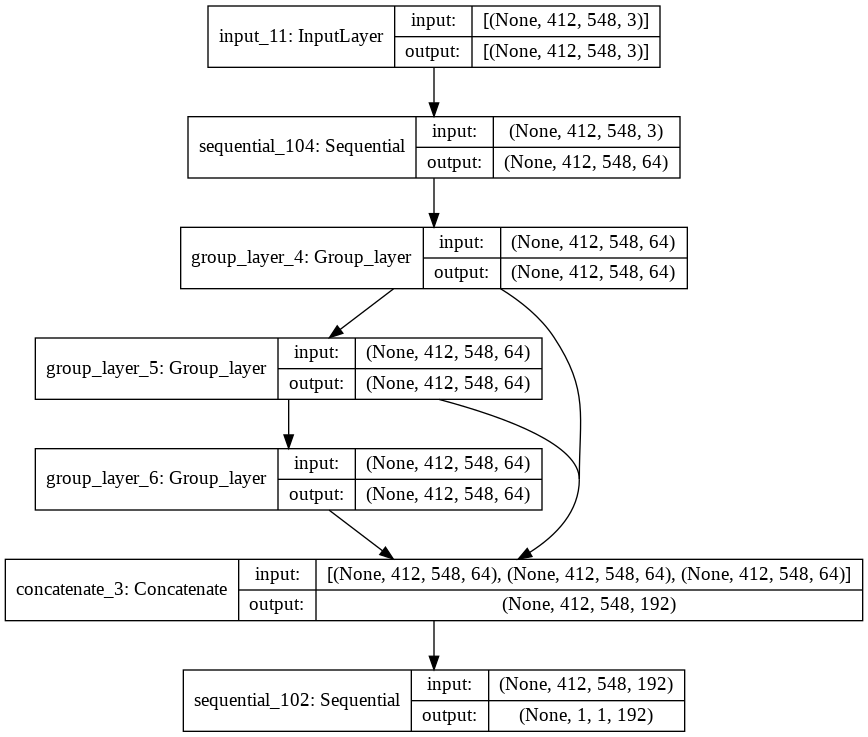

In [25]:
sub =FFAnet(gps=3,blocks=6)
sub.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(
    sub.build_graph(),                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)

In [ ]:
# Hyperparameters
epochs = 10
batch_size = 8
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

train_data, val_data = data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze')
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net = ModelSubClassing()

train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

In [ ]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                #print(train_logits.shape)
                loss = mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()

In [ ]:
%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 [=

KeyboardInterrupt: ignored

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 412, 548, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 412, 548, 64)      1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 412, 548, 3)       1731      
Total params: 3,523
Trainable params: 3,523
Non-trainable params: 0
_________________________________________________________________


## Learn

In [ ]:
import torch.nn as nn
import torch

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size,padding=(kernel_size//2), bias=bias)
    
class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
                nn.Sigmoid()
        )
    def forward(self, x):
        y = self.pa(x)
        return x * y

class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y

class Block(nn.Module):
    def __init__(self, conv, dim, kernel_size,):
        super(Block, self).__init__()
        self.conv1=conv(dim, dim, kernel_size, bias=True)
        self.act1=nn.ReLU(inplace=True)
        self.conv2=conv(dim,dim,kernel_size,bias=True)
        self.calayer=CALayer(dim)
        self.palayer=PALayer(dim)
    def forward(self, x):
        res=self.act1(self.conv1(x))
        res=res+x 
        res=self.conv2(res)
        res=self.calayer(res)
        res=self.palayer(res)
        res += x 
        return res
class Group(nn.Module):
    def __init__(self, conv, dim, kernel_size, blocks):
        super(Group, self).__init__()
        modules = [ Block(conv, dim, kernel_size)  for _ in range(blocks)]
        modules.append(conv(dim, dim, kernel_size))
        self.gp = nn.Sequential(*modules)
    def forward(self, x):
        res = self.gp(x)
        res += x
        return res

class FFA(nn.Module):
    def __init__(self,gps,blocks,conv=default_conv):
        super(FFA, self).__init__()
        self.gps=gps
        self.dim=64
        kernel_size=3
        pre_process = [conv(3, self.dim, kernel_size)]
        assert self.gps==3
        self.g1= Group(conv, self.dim, kernel_size,blocks=blocks)
        self.g2= Group(conv, self.dim, kernel_size,blocks=blocks)
        self.g3= Group(conv, self.dim, kernel_size,blocks=blocks)
        self.ca=nn.Sequential(*[
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.dim*self.gps,self.dim//16,1,padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.dim//16, self.dim*self.gps, 1, padding=0, bias=True),
            nn.Sigmoid()
            ])
        self.palayer=PALayer(self.dim)

        post_precess = [
            conv(self.dim, self.dim, kernel_size),
            conv(self.dim, 3, kernel_size)]

        self.pre = nn.Sequential(*pre_process)
        self.post = nn.Sequential(*post_precess)

    def forward(self, x1):
        x = self.pre(x1)
        res1=self.g1(x)
        res2=self.g2(res1)
        res3=self.g3(res2)
        #return res3
        w=torch.cat([res1,res2,res3],dim=1)
        w=self.ca(w)
        return w
        w=w.view(-1,self.gps,self.dim)[:,:,:,None,None]
        out=w[:,0,::]*res1+w[:,1,::]*res2+w[:,2,::]*res3
        out=self.palayer(out)
        x=self.post(out)
        return x + x1

In [ ]:
from torchsummary import summary
net=FFA(gps=3,blocks=6)
if torch.cuda.is_available():
    net.cuda()
print(summary(net, (3, 412, 548)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 412, 548]           1,792
            Conv2d-2         [-1, 64, 412, 548]          36,928
              ReLU-3         [-1, 64, 412, 548]               0
            Conv2d-4         [-1, 64, 412, 548]          36,928
 AdaptiveAvgPool2d-5             [-1, 64, 1, 1]               0
            Conv2d-6              [-1, 8, 1, 1]             520
              ReLU-7              [-1, 8, 1, 1]               0
            Conv2d-8             [-1, 64, 1, 1]             576
           Sigmoid-9             [-1, 64, 1, 1]               0
          CALayer-10         [-1, 64, 412, 548]               0
           Conv2d-11          [-1, 8, 412, 548]             520
             ReLU-12          [-1, 8, 412, 548]               0
           Conv2d-13          [-1, 1, 412, 548]               9
          Sigmoid-14          [-1, 1, 4